In [18]:
import matplotlib.pyplot as plt
#import numpy as np
import torch
from scipy.linalg import eigh
#from functools import partial
#import torch.optim as optim
import autograd
import autograd.numpy as anp
from autograd import grad
import numpy as np
import scipy.optimize as opt
import time

# Mean-Field of the Hubbard Model  

---

## 1. Hubbard Hamiltonian

We consider the single-band Hubbard model on a square lattice:

$$
\hat H
=
- t \sum_{\langle i,j\rangle,\sigma}
\left(
\hat c_{i\sigma}^\dagger \hat c_{j\sigma}
+ \text{H.c.}
\right)
- \mu \sum_{i,\sigma} \hat n_{i\sigma}
+ U \sum_i \hat n_{i\uparrow} \hat n_{i\downarrow}
$$

where

$$
\hat n_{i\sigma} = \hat c_{i\sigma}^\dagger \hat c_{i\sigma}.
$$

---

## 2. Mean-field decoupling

The interaction term is decoupled in two channels.

---

### 2.1 Antiferromagnetic (AFM) channel

Define the staggered magnetization:

$$
m
=
\frac{U}{2}
\left\langle
\hat n_{i\uparrow} - \hat n_{i\downarrow}
\right\rangle
(-1)^{x_i+y_i}.
$$

The AFM mean-field Hamiltonian becomes:

$$
\hat H_{\mathrm{AFM}}
=
\sum_i
(-1)^{x_i+y_i}
\, m \,
\left(
\hat n_{i\uparrow}
-
\hat n_{i\downarrow}
\right).
$$

---

### 2.2 Superconducting (pairing) channel

Define singlet pairing on nearest-neighbor bonds:

$$
\Delta_{ij}
=
\frac{U}{2}
\left\langle
\hat c_{i\uparrow} \hat c_{j\downarrow}
-
\hat c_{i\downarrow} \hat c_{j\uparrow}
\right\rangle.
$$

For **d-wave symmetry**:

$$
\Delta_{i,i+\hat x} = +\Delta,
\qquad
\Delta_{i,i+\hat y} = -\Delta.
$$

The pairing Hamiltonian is:

$$
\hat H_\Delta
=
\sum_{\langle i,j\rangle}
\Delta_{ij}
\left(
\hat c_{i\uparrow}^\dagger \hat c_{j\downarrow}^\dagger
-
\hat c_{i\downarrow}^\dagger \hat c_{j\uparrow}^\dagger
\right)
+ \text{H.c.}
$$

---

## 3. Mean-field Hamiltonian

The total mean-field Hamiltonian is:

$$
\hat H_{\mathrm{MF}}
=
\hat H_t
+
\hat H_{\mathrm{AFM}}
+
\hat H_\Delta
-
\mu \hat N
+
E_0,
$$

with the constant energy term:

$$
E_0
=
\frac{m^2}{U}
+
\frac{\Delta^2}{U}.
$$

---

## 4. Bogoliubov–de Gennes (BdG) formulation

Define the Nambu spinor at each site:

$$
\Psi_i
=
\begin{pmatrix}
\hat c_{i\uparrow} \\
\hat c_{i\downarrow} \\
\hat c_{i\uparrow}^\dagger \\
\hat c_{i\downarrow}^\dagger
\end{pmatrix}.
$$

The Hamiltonian can be written as:

$$
\hat H_{\mathrm{MF}}
=
\frac{1}{2}
\sum_{i,j}
\Psi_i^\dagger
\mathcal H^{\mathrm{BdG}}_{ij}
\Psi_j
+
E_0.
$$

Diagonalization gives eigenvalues $\{E_n\}$.

---

## 5. Ground-state energy

At zero temperature, all negative BdG eigenvalues are occupied:

$$
E_{\mathrm{GS}}
=
\frac{1}{N}
\sum_{E_n < 0} E_n
+
E_0.
$$

The variational parameters $m$ and $\Delta$ are obtained by minimizing
$E_{\mathrm{GS}}$.

---

U= 0.5, m_AF=-0.019278, time taken = 38.26 s
U= 1.0, m_AF=0.070280, time taken = 27.25 s
U= 2.0, m_AF=0.376107, time taken = 48.35 s
U= 4.0, m_AF=1.381335, time taken = 48.85 s
U= 8.0, m_AF=2.000000, time taken = 34.82 s

Total time for all U values: 197.55 s


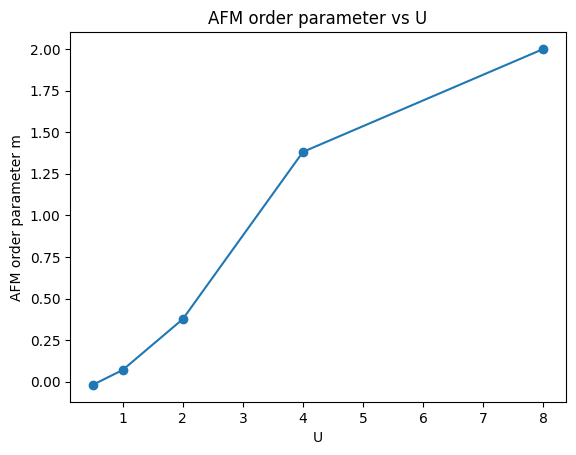

In [ ]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
import time 



def mod(a, b):
    return (a + b) % b

# -------------------------------
# Hubbard Hamiltonian and energies
# -------------------------------

def Hubbard_AF_meanfield_ham(t, t_prime, mu, U, Lx, Ly, m_ord):
    Ns = Lx * Ly
    N = 2 * Ns
    ham = np.zeros((N, N), dtype=float)

    for x in range(Lx):
        for y in range(Ly):
            i = x * Ly + y
            i_up = i
            i_dn = i + Ns

            eta = (-1) ** (x + y)

            ham[i_up, i_up] = -mu + eta * m_ord
            ham[i_dn, i_dn] = -mu - eta * m_ord

            for dx, dy in [(1,0),(0,1)]:
                x2 = mod(x + dx, Lx)
                y2 = mod(y + dy, Ly)
                j = x2 * Ly + y2

                ham[i_up, j] = -t
                ham[j, i_up] = -t
                ham[i_dn, j + Ns] = -t
                ham[j + Ns, i_dn] = -t

            for dx, dy in [(1,1),(-1,-1)]:
                x2 = mod(x + dx, Lx)
                y2 = mod(y + dy, Ly)
                j = x2 * Ly + y2

                ham[i_up, j] = -t_prime
                ham[j, i_up] = -t_prime
                ham[i_dn, j + Ns] = -t_prime
                ham[j + Ns, i_dn] = -t_prime

    return ham

def e0val_AF(m_ord, U):
    return (m_ord ** 2) / U

def compute_ground_state_energy(Lx, Ly, e0, eigenvalues):
    return np.sum(eigenvalues[eigenvalues < 0]) / (Lx * Ly) + e0

def objective_function_m(m_ord, t, t_prime, mu, U, Lx, Ly):
    ham = Hubbard_AF_meanfield_ham(t, t_prime, mu, U, Lx, Ly, m_ord[0])
    eigvals = np.linalg.eigh(ham)[0]
    e0 = e0val_AF(m_ord[0], U)
    return compute_ground_state_energy(Lx, Ly, e0, eigvals)

# -------------------------------
# -------------------------------
if __name__ == "__main__":

    t = 1.0
    t_prime = 0.0
    Lx, Ly = 40, 40
    mu = 0.0
    U_values = [0.5, 1, 2, 4, 8]
    m_opt = []

    # Total time tracking
    total_start = time.time()

    for U in U_values:
        # Start timing for this U
        start_time = time.time()

        res = opt.minimize(
            objective_function_m,
            x0=np.array([0.1]),
            args=(t, t_prime, mu, U, Lx, Ly),
            method="L-BFGS-B",
            bounds=[(-2.0, 2.0)]
        )

        end_time = time.time()  # End timing for this U
        elapsed_time = end_time - start_time

        if res.success:
            m_opt.append(res.x[0])
            print(f"U={U:4.1f}, m_AF={res.x[0]:.6f}, time taken = {elapsed_time:.2f} s")
        else:
            m_opt.append(np.nan)
            print(f"U={U} optimization failed, time taken = {elapsed_time:.2f} s")

    total_end = time.time()
    print(f"\nTotal time for all U values: {total_end - total_start:.2f} s")

    # Plots
    plt.plot(U_values, m_opt, "o-")
    plt.xlabel("U")
    plt.ylabel("AFM order parameter m")
    plt.title("AFM order parameter vs U")
    plt.show()


# Magnetic and superconducting order parameters


Optimizing for U = 1
  m     = 0.040750
  Delta = 1.419869

Optimizing for U = 2
  m     = 0.117826
  Delta = 2.000000

Optimizing for U = 4
  m     = 1.672054
  Delta = 2.000000

Optimizing for U = 6
  m     = 2.000000
  Delta = 2.000000

Optimizing for U = 8
  m     = 2.000000
  Delta = 2.000000


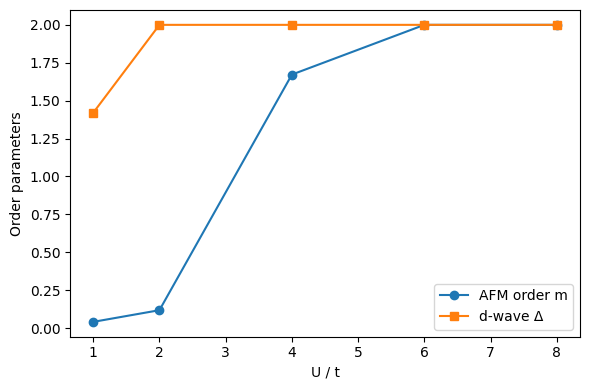

In [ ]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt



def mod(a, b):
    """Periodic boundary condition"""
    return (a + b) % b


def site_index(x, y, Ly):
    """Map (x,y) -> site index"""
    return x * Ly + y


# -------------------------------
# BdG Hamiltonian construction
# -------------------------------

def Hubbard_AFM_dwave_BdG(t, mu, U, Lx, Ly, m_ord, Delta_ord):
    """
    Real-space BdG Hamiltonian for Hubbard model
    with AFM + d-wave pairing.

    Nambu basis:
    (c_up, c_down, c_up^†, c_down^†)
    """

    Ns = Lx * Ly
    N = 4 * Ns
    H = np.zeros((N, N))

    def idx(i, spin, particle):
        """
        spin: 0 = up, 1 = down
        particle: 0 = particle, 1 = hole
        """
        return i + spin * Ns + particle * 2 * Ns

    for x in range(Lx):
        for y in range(Ly):
            i = site_index(x, y, Ly)

            # AFM staggered factor
            eta = (-1) ** (x + y)

            # -------------------
            # Onsite terms
            # -------------------
            H[idx(i,0,0), idx(i,0,0)] = -mu + eta * m_ord
            H[idx(i,1,0), idx(i,1,0)] = -mu - eta * m_ord
            H[idx(i,0,1), idx(i,0,1)] =  mu - eta * m_ord
            H[idx(i,1,1), idx(i,1,1)] =  mu + eta * m_ord

            # -------------------
            # Nearest neighbors
            # -------------------
            for dx, dy, sign in [(1,0,+1), (0,1,-1)]:
                x2 = mod(x + dx, Lx)
                y2 = mod(y + dy, Ly)
                j = site_index(x2, y2, Ly)

                # Hopping
                for s in [0,1]:
                    H[idx(i,s,0), idx(j,s,0)] += -t
                    H[idx(j,s,0), idx(i,s,0)] += -t
                    H[idx(i,s,1), idx(j,s,1)] +=  t
                    H[idx(j,s,1), idx(i,s,1)] +=  t

                # d-wave singlet pairing
                Delta = sign * Delta_ord

                H[idx(i,0,0), idx(j,1,1)] +=  Delta
                H[idx(j,0,0), idx(i,1,1)] +=  Delta
                H[idx(i,1,0), idx(j,0,1)] += -Delta
                H[idx(j,1,0), idx(i,0,1)] += -Delta

                # Hermitian conjugate
                H[idx(j,1,1), idx(i,0,0)] +=  Delta
                H[idx(i,1,1), idx(j,0,0)] +=  Delta
                H[idx(j,0,1), idx(i,1,0)] += -Delta
                H[idx(i,0,1), idx(j,1,0)] += -Delta

    return H


# -------------------------------
# Mean-field constant energy
# -------------------------------

def e0val(m_ord, Delta_ord, U):
    """
    Mean-field constant energy
    """
    return (m_ord**2 + Delta_ord**2) / U


# -------------------------------
# Ground-state energy
# -------------------------------

def ground_state_energy(Lx, Ly, eigvals, e0):
    """
    Fill all negative BdG eigenvalues
    """
    return np.sum(eigvals[eigvals < 0]) / (Lx * Ly) + e0


# -------------------------------
# Objective function
# -------------------------------

def objective(params, t, mu, U, Lx, Ly):
    """
    params = [m, Delta]
    """
    m, Delta = params

    H = Hubbard_AFM_dwave_BdG(
        t=t,
        mu=mu,
        U=U,
        Lx=Lx,
        Ly=Ly,
        m_ord=m,
        Delta_ord=Delta
    )

    eigvals = np.linalg.eigh(H)[0]
    e0 = e0val(m, Delta, U)

    return ground_state_energy(Lx, Ly, eigvals, e0)


if __name__ == "__main__":

    # Model parameters
    t = 1.0
    mu = 0.0
    Lx, Ly = 12, 12

    U_list = [1, 2, 4, 6, 8]
    m_list = []
    Delta_list = []

    for U in U_list:
        print(f"\nOptimizing for U = {U}")
        start_time = time.time()

        result = opt.minimize(
            objective,
            x0=[0.1, 0.1],
            args=(t, mu, U, Lx, Ly),
            method="L-BFGS-B",
            bounds=[(-2.0, 2.0), (-2.0, 2.0)]
        )

        end_time = time.time()  # End timing for this U
        elapsed_time = end_time - start_time


        if result.success:
            m_opt, Delta_opt = result.x
            m_list.append(m_opt)
            Delta_list.append(Delta_opt)

            print(f"  m     = {m_opt:.6f}")
            print(f"  Delta = {Delta_opt:.6f}")
        else:
            m_list.append(np.nan)
            Delta_list.append(np.nan)
            print("  Optimization failed")
    
    total_end = time.time()

    print(f"\nTotal time for all U values: {total_end - total_start:.2f} s")
    # -------------------------------
    # Plots
    # -------------------------------
    plt.figure(figsize=(6,4))
    plt.plot(U_list, m_list, "o-", label="AFM order m")
    plt.plot(U_list, Delta_list, "s-", label="d-wave Δ")
    plt.xlabel("U / t")
    plt.ylabel("Order parameters")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Optimization using Jax autograd for magnetic ordering

U=1, m=0.11914587765932083
U=2, m=0.3961854577064514
U=4, m=1.3681318759918213
U=8, m=3.347369432449341

Total time for all U values: 45068.09 s


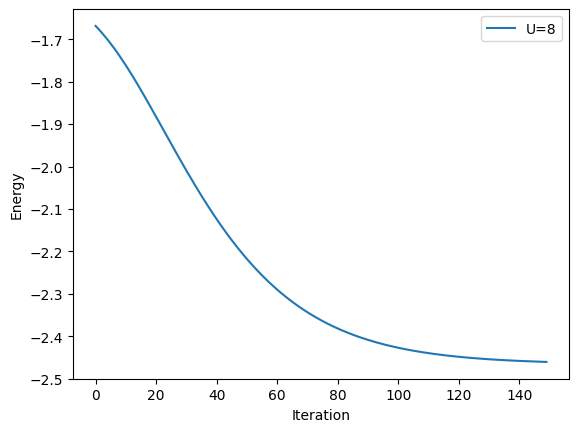

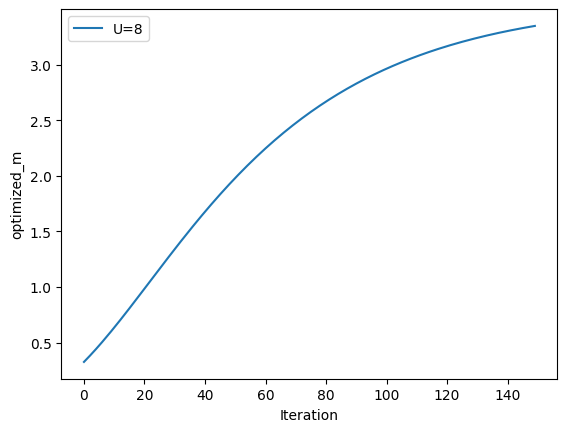

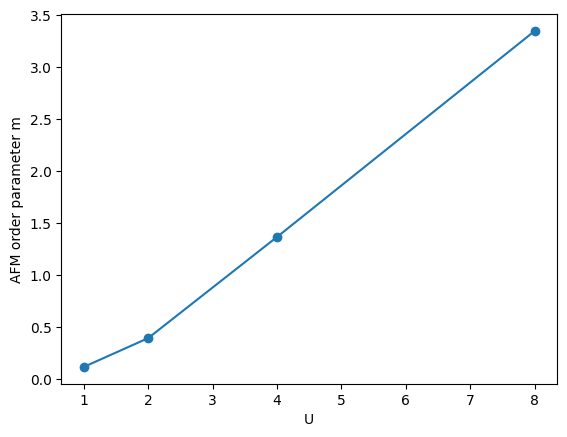

In [29]:
import jax.numpy as jnp
from jax import grad
import matplotlib.pyplot as plt


def mod(a, b):
    return (a + b) % b


def square_latt(Lx, Ly):
    Ns = Lx * Ly
    loc = jnp.zeros((Lx, Ly), dtype=jnp.int32)
    nbr = jnp.zeros((Ns, 2), dtype=jnp.int32)
    nnbr = jnp.zeros((Ns, 2), dtype=jnp.int32)

    site = 0
    for x in range(Lx):
        for y in range(Ly):
            loc = loc.at[x, y].set(site)
            site += 1

    for x in range(Lx):
        for y in range(Ly):
            i = loc[x, y]
            nbr = nbr.at[i, 0].set(loc[mod(x+1, Lx), y])
            nbr = nbr.at[i, 1].set(loc[x, mod(y+1, Ly)])
            nnbr = nnbr.at[i, 0].set(loc[mod(x+1, Lx), mod(y+1, Ly)])
            nnbr = nnbr.at[i, 1].set(loc[mod(x+1, Lx), mod(y-1, Ly)])

    return loc, nbr, nnbr


def Hubbard_AF_meanfield_ham(t, t_prime, mu, U, Lx, Ly, m):
    Ns = Lx * Ly
    N = 2 * Ns
    ham = jnp.zeros((N, N))

    loc, nbr, nnbr = square_latt(Lx, Ly)

    for x in range(Lx):
        for y in range(Ly):
            i = loc[x, y]
            eta = (-1)**(x + y)

            i_up = i
            i_dn = i + Ns

            # AFM onsite
            ham = ham.at[i_up, i_up].set(-mu + eta * m)
            ham = ham.at[i_dn, i_dn].set(-mu - eta * m)

            # NN hopping
            for k in range(2):
                j = nbr[i, k]
                ham = ham.at[i_up, j].set(-t)
                ham = ham.at[j, i_up].set(-t)
                ham = ham.at[i_dn, j + Ns].set(-t)
                ham = ham.at[j + Ns, i_dn].set(-t)

            # NNN hopping
            for k in range(2):
                j = nnbr[i, k]
                ham = ham.at[i_up, j].set(-t_prime)
                ham = ham.at[j, i_up].set(-t_prime)
                ham = ham.at[i_dn, j + Ns].set(-t_prime)
                ham = ham.at[j + Ns, i_dn].set(-t_prime)

    return ham


def e0val(U, m):
    return m * m / U


def objective_function(params, t, t_prime, mu, U, Lx, Ly):
    m = params[0]
    H = Hubbard_AF_meanfield_ham(t, t_prime, mu, U, Lx, Ly, m)
    eigvals = jnp.linalg.eigvalsh(H)
    e0 = e0val(U, m)
    return jnp.sum(eigvals[eigvals < 0]) / (Lx * Ly) + e0

if __name__ == "__main__":
    t = 1.0
    t_prime = 0.0
    mu = 0.0
    Lx = 12
    Ly = 12
    itr = 150

    #U_values = [0.1, 0.5, 1, 2, 4, 8]
    U_values = [1, 2, 4, 8]
    optimized_m = []

    grad_obj = grad(objective_function)

    for U in U_values:
        start_time = time.time()
        params = jnp.array([0.3])
        lr = 0.1
        losses = []
        m_epoch = []

        for _ in range(itr):
            loss = objective_function(params, t, t_prime, mu, U, Lx, Ly)
            losses.append(loss)
            g = grad_obj(params, t, t_prime, mu, U, Lx, Ly)
            params = params - lr * g
            m_epoch.append(params[0])

        optimized_m.append(params[0])
        print(f"U={U}, m={params[0]}")
        
    end_time = time.time()  # End timing for this U
    elapsed_time = end_time - start_time
   
    total_end = time.time()
    print(f"\nTotal time for all U values: {total_end - total_start:.2f} s")
    plt.plot(losses, label=f"U={U}")
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.show()
    
    plt.plot(m_epoch, label=f"U={U}")
    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("optimized_m")
    plt.show()

    plt.plot(U_values, optimized_m, "o-")
    plt.xlabel("U")
    plt.ylabel("AFM order parameter m")
    plt.show()


U=2, m=0.42554059624671936
U=4, m=1.1730140447616577
U=8, m=2.2430810928344727
U=16, m=3.210472822189331

Total time for all U values: 2102.69 s


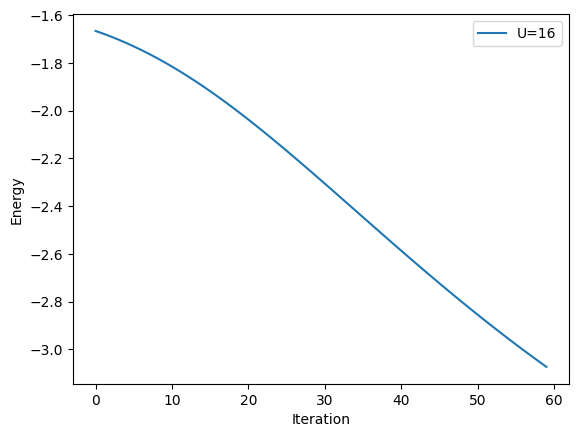

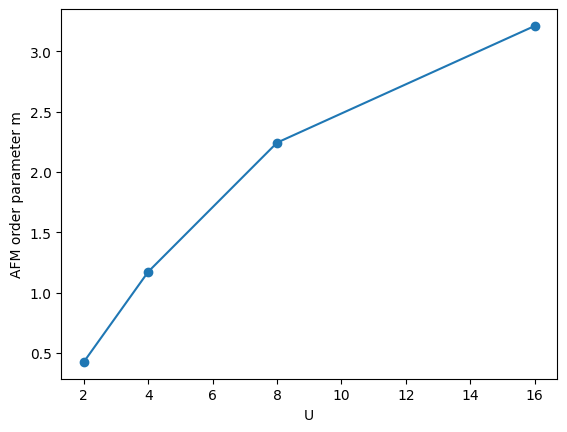

In [21]:
import jax.numpy as jnp
from jax import grad
import matplotlib.pyplot as plt


def mod(a, b):
    return (a + b) % b


def square_latt(Lx, Ly):
    Ns = Lx * Ly
    loc = jnp.zeros((Lx, Ly), dtype=jnp.int32)
    nbr = jnp.zeros((Ns, 2), dtype=jnp.int32)
    nnbr = jnp.zeros((Ns, 2), dtype=jnp.int32)

    site = 0
    for x in range(Lx):
        for y in range(Ly):
            loc = loc.at[x, y].set(site)
            site += 1

    for x in range(Lx):
        for y in range(Ly):
            i = loc[x, y]
            nbr = nbr.at[i, 0].set(loc[mod(x+1, Lx), y])
            nbr = nbr.at[i, 1].set(loc[x, mod(y+1, Ly)])
            nnbr = nnbr.at[i, 0].set(loc[mod(x+1, Lx), mod(y+1, Ly)])
            nnbr = nnbr.at[i, 1].set(loc[mod(x+1, Lx), mod(y-1, Ly)])

    return loc, nbr, nnbr


def Hubbard_AF_meanfield_ham(t, t_prime, mu, U, Lx, Ly, m):
    Ns = Lx * Ly
    N = 2 * Ns
    ham = jnp.zeros((N, N))

    loc, nbr, nnbr = square_latt(Lx, Ly)

    for x in range(Lx):
        for y in range(Ly):
            i = loc[x, y]
            eta = (-1)**(x + y)

            i_up = i
            i_dn = i + Ns

            # AFM onsite
            ham = ham.at[i_up, i_up].set(-mu + eta * m)
            ham = ham.at[i_dn, i_dn].set(-mu - eta * m)

            # NN hopping
            for k in range(2):
                j = nbr[i, k]
                ham = ham.at[i_up, j].set(-t)
                ham = ham.at[j, i_up].set(-t)
                ham = ham.at[i_dn, j + Ns].set(-t)
                ham = ham.at[j + Ns, i_dn].set(-t)

            # NNN hopping
            for k in range(2):
                j = nnbr[i, k]
                ham = ham.at[i_up, j].set(-t_prime)
                ham = ham.at[j, i_up].set(-t_prime)
                ham = ham.at[i_dn, j + Ns].set(-t_prime)
                ham = ham.at[j + Ns, i_dn].set(-t_prime)

    return ham


def e0val(U, m):
    return m * m / U


def objective_function(params, t, t_prime, mu, U, Lx, Ly):
    m = params[0]
    H = Hubbard_AF_meanfield_ham(t, t_prime, mu, U, Lx, Ly, m)
    eigvals = jnp.linalg.eigvalsh(H)
    e0 = e0val(U, m)
    return jnp.sum(eigvals[eigvals < 0]) / (Lx * Ly) + e0

if __name__ == "__main__":
    t = 1.0
    t_prime = 0.0
    mu = 0.0
    Lx = 8
    Ly = 8
    itr = 60

    U_values = [2, 4, 8, 16]
    optimized_m = []

    grad_obj = grad(objective_function)

    for U in U_values:
        start_time = time.time()
        params = jnp.array([0.3])
        lr = 0.1
        losses = []

        for _ in range(itr):
            loss = objective_function(params, t, t_prime, mu, U, Lx, Ly)
            losses.append(loss)
            g = grad_obj(params, t, t_prime, mu, U, Lx, Ly)
            params = params - lr * g

        optimized_m.append(params[0])
        print(f"U={U}, m={params[0]}")
        
    end_time = time.time()  # End timing for this U
    elapsed_time = end_time - start_time
   
    total_end = time.time()
    print(f"\nTotal time for all U values: {total_end - total_start:.2f} s")

    plt.plot(losses, label=f"U={U}")
    

    plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.show()

    plt.plot(U_values, optimized_m, "o-")
    plt.xlabel("U")
    plt.ylabel("AFM order parameter m")
    plt.show()


## Jax autograd for magnetic ordering and superconducting parameter

In [ ]:
import jax.numpy as jnp
from jax import grad
import matplotlib.pyplot as plt



Optimizing for U = 0.1
  m     = 0.007179
  Delta = 0.067634

Optimizing for U = 1
  m     = 0.098178
  Delta = 1.294909

Optimizing for U = 2
  m     = 0.204772
  Delta = 2.185282

Optimizing for U = 4
  m     = 0.320486
  Delta = 2.971010

Optimizing for U = 6
  m     = 0.375948
  Delta = 3.315915

Optimizing for U = 8
  m     = 0.407886
  Delta = 3.508115

Optimizing for U = 16
  m     = 0.461888
  Delta = 3.824360


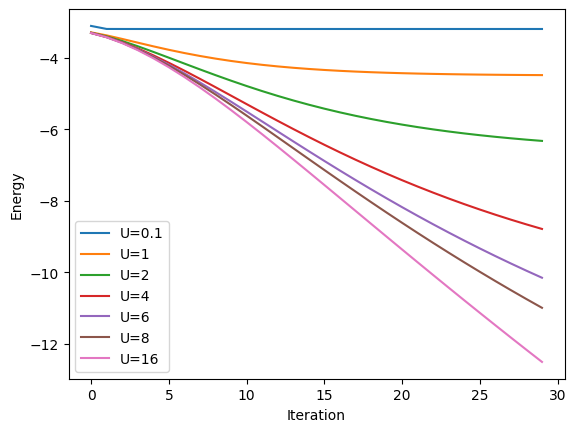

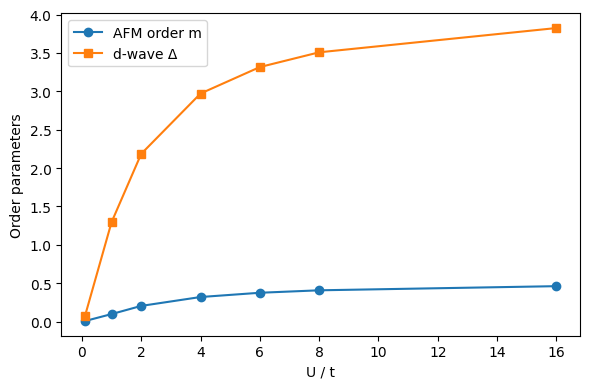

In [13]:
def mod(a, b):
    return (a + b) % b


def site_index(x, y, Ly):
    return x * Ly + y


def Hubbard_AFM_dwave_BdG(t, mu, Lx, Ly, m_ord, Delta_ord):
    Ns = Lx * Ly
    N = 4 * Ns
    H = jnp.zeros((N, N))

    def idx(i, spin, particle):
        return i + spin * Ns + particle * 2 * Ns

    for x in range(Lx):
        for y in range(Ly):
            i = site_index(x, y, Ly)
            eta = (-1) ** (x + y)

            # Onsite AFM + chemical potential
            H = H.at[idx(i,0,0), idx(i,0,0)].set(-mu + eta * m_ord)
            H = H.at[idx(i,1,0), idx(i,1,0)].set(-mu - eta * m_ord)
            H = H.at[idx(i,0,1), idx(i,0,1)].set( mu - eta * m_ord)
            H = H.at[idx(i,1,1), idx(i,1,1)].set( mu + eta * m_ord)

            # Nearest neighbors
            for dx, dy, sign in [(1,0,+1), (0,1,-1)]:
                x2 = mod(x + dx, Lx)
                y2 = mod(y + dy, Ly)
                j = site_index(x2, y2, Ly)

                # hopping
                for s in [0, 1]:
                    H = H.at[idx(i,s,0), idx(j,s,0)].add(-t)
                    H = H.at[idx(j,s,0), idx(i,s,0)].add(-t)
                    H = H.at[idx(i,s,1), idx(j,s,1)].add( t)
                    H = H.at[idx(j,s,1), idx(i,s,1)].add( t)

                # d-wave pairing
                Delta = sign * Delta_ord
                H = H.at[idx(i,0,0), idx(j,1,1)].add( Delta)
                H = H.at[idx(j,0,0), idx(i,1,1)].add( Delta)
                H = H.at[idx(i,1,0), idx(j,0,1)].add(-Delta)
                H = H.at[idx(j,1,0), idx(i,0,1)].add(-Delta)

                # Hermitian conjugate
                H = H.at[idx(j,1,1), idx(i,0,0)].add( Delta)
                H = H.at[idx(i,1,1), idx(j,0,0)].add( Delta)
                H = H.at[idx(j,0,1), idx(i,1,0)].add(-Delta)
                H = H.at[idx(i,0,1), idx(j,1,0)].add(-Delta)

    return H

def e0val(m_ord, Delta_ord, U):
    return (m_ord**2 + Delta_ord**2) / U


def ground_state_energy(Lx, Ly, eigvals, e0):
    return jnp.sum(eigvals[eigvals < 0]) / (Lx * Ly) + e0

def objective(params, t, mu, U, Lx, Ly):
    m, Delta = params

    H = Hubbard_AFM_dwave_BdG(
        t=t,
        mu=mu,
        Lx=Lx,
        Ly=Ly,
        m_ord=m,
        Delta_ord=Delta
    )

    eigvals = jnp.linalg.eigvalsh(H)
    e0 = e0val(m, Delta, U)

    return ground_state_energy(Lx, Ly, eigvals, e0)

if __name__ == "__main__":
    t = 1.0
    mu = 0.0
    Lx, Ly = 8, 8
    itr = 30
    lr = 0.05

    U_list = [0.1, 1, 2, 4, 6, 8, 16]
    m_list = []
    Delta_list = []

    grad_obj = grad(objective)

    for U in U_list:
        print(f"\nOptimizing for U = {U}")

        params = jnp.array([0.1, 0.1])  # [m, Delta]
        losses = []

        for _ in range(itr):
            loss = objective(params, t, mu, U, Lx, Ly)
            losses.append(loss)

            g = grad_obj(params, t, mu, U, Lx, Ly)
            params = params - lr * g

        m_opt, Delta_opt = params
        m_list.append(m_opt)
        Delta_list.append(Delta_opt)

        print(f"  m     = {float(m_opt):.6f}")
        print(f"  Delta = {float(Delta_opt):.6f}")

        plt.plot(losses, label=f"U={U}")

    plt.xlabel("Iteration")
    plt.ylabel("Energy")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(U_list, m_list, "o-", label="AFM order m")
    plt.plot(U_list, Delta_list, "s-", label="d-wave Δ")
    plt.xlabel("U / t")
    plt.ylabel("Order parameters")
    plt.legend()
    plt.tight_layout()
    plt.show()
